## Visual Anagrams: Generating Multi-View Optical Illusions with Diffusion Models
This notebook generates visual anagrams and other multi-view optical illusions. These are images that change appearance or identity when transformed, such as by a rotation or a permutation of pixels.

### DeepFloyd Access
Our method uses DeepFloyd IF, a pixel-based diffusion model. We do not use Stable Diffusion because latent diffusion models cause artifacts in illusions.

Before using DeepFloyd IF, you must accept its usage conditions. To do so:

* Make sure to have a Hugging Face account and be logged in.
* Accept the license on the model card of DeepFloyd/IF-I-XL-v1.0. Accepting the license on the stage I model card will auto accept for the other IF models.
* Log in locally by entering your Hugging Face Hub access token below.

In [1]:
from huggingface_hub import login

token = "hugging_face_token"
login(token=token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Install Dependencies
Run the below to install dependencies, including the visual_anagrams repo which will do the heavy lifting.

In [2]:
! pip install -q \
  diffusers \
  transformers \
  safetensors \
  sentencepiece \
  accelerate \
  bitsandbytes \
  einops \
  mediapy

!pip install -q git+https://github.com/dangeng/visual_anagrams.git

## Import Dependencies and Misc Setup
We import packages we need and define some useful functions

In [3]:
import mediapy as mp

import torch
from diffusers import DiffusionPipeline

from visual_anagrams.views import get_views
from visual_anagrams.samplers import sample_stage_1, sample_stage_2
from visual_anagrams.utils import add_args, save_illusion, save_metadata

device = 'cuda'

def im_to_np(im):
  im = (im / 2 + 0.5).clamp(0, 1)
  im = im.detach().cpu().permute(1, 2, 0).numpy()
  im = (im * 255).round().astype("uint8")
  return im

2024-08-05 14:33:15.394527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 14:33:15.394593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 14:33:15.398510: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load Models
This may take a while. We're using the `DeepFloyd IF models`, and they are quite big. (If the below code fails, check that you've followed the instructions at the top of this notebook. You must accept the DeepFloyd IF conditions AND log in to huggingface locally).

In [4]:
# Load DeepFloyd IF stage I
stage_1 = DiffusionPipeline.from_pretrained(
                "DeepFloyd/IF-I-M-v1.0",
                variant="fp16",
                torch_dtype=torch.float16,
              )
stage_1.enable_model_cpu_offload()
stage_1 = stage_1.to(device)

# Load DeepFloyd IF stage II
stage_2 = DiffusionPipeline.from_pretrained(
                "DeepFloyd/IF-II-M-v1.0",
                text_encoder=None,
                variant="fp16",
                torch_dtype=torch.float16,
              )
stage_2.enable_model_cpu_offload()
stage_2 = stage_2.to(device)

# Load DeepFloyd IF stage III
# (which is just Stable Diffusion 4x Upscaler)
stage_3 = DiffusionPipeline.from_pretrained(
                "stabilityai/stable-diffusion-x4-upscaler",
                torch_dtype=torch.float16
            )
stage_3.enable_model_cpu_offload()
stage_3 = stage_3.to(device)

safety_checker/model.safetensors not found

A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[unet/diffusion_pytorch_model.fp16.bin, text_encoder/pytorch_model.fp16-00002-of-00002.bin, text_encoder/pytorch_model.fp16-00001-of-00002.bin]
Loaded non-fp16 filenames:
[safety_checker/pytorch_model.bin, watermarker/diffusion_pytorch_model.bin
If this behavior is not expected, please check your folder structure.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--DeepFloyd--IF-I-M-v1.0/snapshots/64dfba780d63640fda95964acba4f410e0420d5f/watermarker: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--DeepFloyd--IF-I-M-v1.0/snapshots/64dfba780d63640fda95964acba4f410e0420d5f/watermarker.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--DeepFloyd--IF-I-M-v1.0/snapshots/64dfba780d63640fda95964acba4f410e0420d5f/unet:

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components tokenizer, text_encoder, unet, scheduler, safety_checker, feature_extractor, watermarker to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.

A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder/model.fp16-00002-of-00002.safetensors, text_encoder/model.fp16-00001-of-00002.safetensors, safety_checker/model.fp16.safetensors, unet/diffusion_pytorch_model.fp16.safetensors]
Loaded non-fp16 filenames:
[watermarker/diffusion_pytorch_model.safetensors
If this behavior is not expected, please check your folder str

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components tokenizer, text_encoder, unet, scheduler, image_noising_scheduler, safety_checker, feature_extractor, watermarker to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokenizer, unet, low_res_scheduler, scheduler, safety_checker, watermarker, feature_extractor to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


## Prompts and Views
To generate an illusion, we need to provide a list of views and a corresponding list of prompt embeddings. We start with the list of views, which we can get by passing a list of strings to the `get_views` function. For a list of views and their implementation see the `views.py` file. Views inherit from the `BaseView` class, so you can implement your own views if you want.

## The Art of Choosing Prompts
**Choosing prompts for illusions can be fairly tricky and unintuitive**. Many prompts simply won't make for good illusions, because they are too hard. Here are some tips:

* Styles such as "a photo of" tend to be harder as the constraint of realism is fairly difficult (but this doesn't mean they can't work!).
* Conversely, styles such as "an oil painting of" seem to do better because there's more freedom to how it can be depicted and interpreted.
* In a similar vein, subjects that allow for high degrees of flexibility in depiction tend to be good. For example, prompts such as "houseplants" or "wine and cheese" or "a kitchen"
* But be careful the subject is still easily recognizable. Illusions are much better when they are instantly understandable.
* Faces often make for very good "hidden" subjects. This is probably because the human visual system is particularly adept at picking out faces. For example, "an old man" or "marilyn monroe" tend to be good subjects.
* Perhaps a bit evident, but 3 view and 4 view illusions are considerably more difficult to get to work.
* Intuition and reasoning works less often than you would expect. Prompts that you think would work great often work poorly, and vice versa. So exploration is key.

In [5]:

# UNCOMMENT ONE OF THESE

views = get_views(['identity', 'rotate_180'])
# views = get_views(['identity', 'rotate_cw'])
# views = get_views(['identity', 'rotate_ccw'])
# views = get_views(['identity', 'flip'])
#views = get_views(['identity', 'negate'])
# views = get_views(['identity', 'skew'])
#views = get_views(['identity', 'patch_permute'])
# views = get_views(['identity', 'pixel_permute'])
# views = get_views(['identity', 'inner_circle'])
# views = get_views(['identity', 'square_hinge'])
# views = get_views(['identity', 'jigsaw'])

Next, we need text prompts. We can specify a list of strings, and pass it into the `encode_prompt` function.

In [6]:
# Feel free to change me:
# prompt_1 = 'A kangaroo wearing an orange hoodie and blue sunglasses'
# prompt_2 = 'The kangaroo is standing in front of the Eiffel Tower and holding a sign that says "very deep learning"'

prompt_1 = 'Photo of a forest fire'
prompt_2 = 'Photo of a car'

# Embed prompts using the T5 model
prompts = [prompt_1, prompt_2]
prompt_embeds = [stage_1.encode_prompt(prompt) for prompt in prompts]
prompt_embeds, negative_prompt_embeds = zip(*prompt_embeds)
prompt_embeds = torch.cat(prompt_embeds)
negative_prompt_embeds = torch.cat(negative_prompt_embeds)  # These are just null embeds

## Generate Illusions
Now, we can sample illusions by denoising all views at once. The `sample_stage_1` function does this and generates a `64 x 64` image. The `sample_stage_2` function upsamples the resulting image while denoising all views, and generates a `256 x 256` image.

100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


,

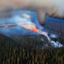
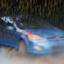

In [7]:
image_64 = sample_stage_1(stage_1,
                          prompt_embeds,
                          negative_prompt_embeds,
                          views,
                          num_inference_steps=30,
                          guidance_scale=10.0,
                          reduction='mean',
                          generator=None)
mp.show_images([im_to_np(view.view(image_64[0])) for view in views])

100%|██████████| 30/30 [00:20<00:00,  1.49it/s]


,

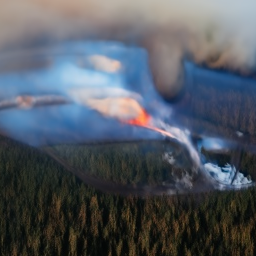
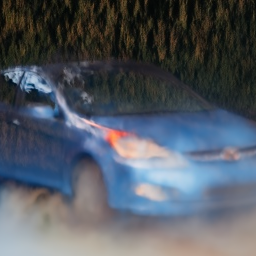

In [8]:
image_256 = sample_stage_2(stage_2,
                           image_64,
                           prompt_embeds,
                           negative_prompt_embeds,
                           views,
                           num_inference_steps=30,
                           guidance_scale=10.0,
                           reduction='mean',
                           noise_level=50,
                           generator=None)
mp.show_images([im_to_np(view.view(image_256[0])) for view in views])

/opt/conda/lib/python3.10/site-packages/diffusers/image_processor.py:582: FutureWarning: Passing `image` as torch tensor with value range in [-1,1] is deprecated. The expected value range for image tensor is [0,1] when passing as pytorch tensor or numpy Array. You passed `image` with value range [-1.0,1.0]
  warnings.warn(


  0%|          | 0/75 [00:00<?, ?it/s]

,

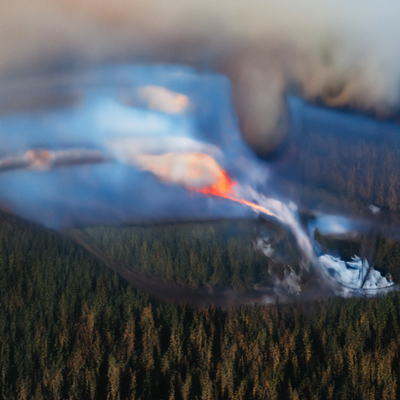
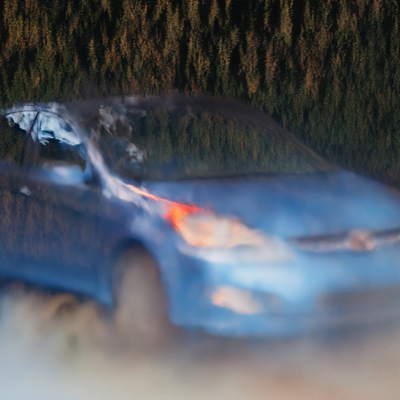

In [9]:
image_1024 = stage_3(
                prompt=prompts[0],  # Note this is a string, and not an embedding
                image=image_256,
                noise_level=0,
                output_type='pt',
                generator=None).images
image_1024 = image_1024 * 2 - 1

# Limit display size, otherwise it's too large for most screens
mp.show_images([im_to_np(view.view(image_1024[0])) for view in views], width=400)

## Animating the Illusion
We will use the `animate_two_view` function to make a video of the illusion. This function takes in a PIL image of the illusion, a view object (which should implement `make_frame`), and animates the transformation defined by the view. We will save the video to `save_video_path`.

The animation function works for all three sizes: `image_64`, `image_256`, or `image_1024` (thought it takes about a minute for size `1024`).

In [10]:
from visual_anagrams.animate import animate_two_view
import torchvision.transforms.functional as TF

##############################
# UNCOMMENT FOR DESIRED SIZE #
##############################
#image = image_64
#image = image_256
image = image_1024

# Get size
im_size = image.shape[-1]
frame_size = int(im_size * 1.5)

# Make save path
save_video_path = './animation.mp4'

# Convert to PIL
pil_image = TF.to_pil_image(image[0] / 2. + 0.5)

# Make the animation
animate_two_view(
            pil_image,
            views[1], # Use the non-identity view to transform
            prompt_1,
            prompt_2,
            save_video_path=save_video_path,
            hold_duration=120,
            text_fade_duration=10,
            transition_duration=45,
            im_size=im_size,
            frame_size=frame_size,
        )

# Display the video (using max width of 600 so will fit on most screens)
mp.show_video(mp.read_video(save_video_path), fps=30, width=min(600, frame_size))

Making frames...


100%|██████████| 45/45 [00:03<00:00, 12.48it/s]


Making video...


/opt/conda/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [ ]:
!pip install moviepy

In [ ]:
from visual_anagrams.animate import animate_two_view
import torchvision.transforms.functional as TF
from moviepy.editor import VideoFileClip

##############################
# UNCOMMENT FOR DESIRED SIZE #
##############################
# image = image_64
# image = image_256
image = image_1024

# Get size
im_size = image.shape[-1]
frame_size = int(im_size * 1.5)

# Make save path
save_video_path = './animation.mp4'

# Convert to PIL
pil_image = TF.to_pil_image(image[0] / 2. + 0.5)

# Make the animation
animate_two_view(
    pil_image,
    views[1], # Use the non-identity view to transform
    prompt_1,
    prompt_2,
    save_video_path=save_video_path,
    hold_duration=120,
    text_fade_duration=10,
    transition_duration=45,
    im_size=im_size,
    frame_size=frame_size,
)

# Convert video to MP4 using moviepy if necessary
try:
    # Check if the video was created properly
    clip = VideoFileClip(save_video_path)
    clip.write_videofile('./animation_converted.mp4', codec='libx264')
    save_video_path = './animation_converted.mp4'  # Update path to converted video
except Exception as e:
    print(f"An error occurred while converting the video: {e}")

# Display the video (using max width of 600 so will fit on most screens)
import matplotlib.pyplot as plt
import matplotlib.animation as mp

def show_video(video_path, fps=30, width=600):
    clip = VideoFileClip(video_path)
    clip = clip.resize(width=width)
    plt.figure(figsize=(width / 100, width / 100 * clip.h / clip.w))
    plt.axis('off')
    plt.imshow(clip.get_frame(0))
    plt.show()

show_video(save_video_path, fps=30, width=min(600, frame_size))
